# Inicialization
Importing libraries and setting up the simulation material

In [367]:
import sys, os
import importlib.util
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import io
import pandas as pd
import seaborn as sns
from scipy.constants import lambda2nu, nu2lambda, c
from PIL import Image

In [368]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math
from IPython.display import Image as IPImage, display

In [97]:
lumapiFile = r"C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)
modeapi = lumapi.MODE(hide = False)

C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [98]:
um = 1e-6
nm = 1e-9

In [99]:
# Materials
material_Clad = "SiO2 (Glass) - Palik"
material_Si = "Si (Silicon) - Dispersive & Lossless"

# Add material Si
matname = material_Si
matReturn = modeapi.getmaterial(material_Si)
if (modeapi.findstring(matReturn, 'is not available') != -1):
    newmaterial = modeapi.addmaterial("Lorentz")
    modeapi.setmaterial(newmaterial, "name", matname)
    modeapi.setmaterial(matname, "Permittivity", 7.98737492)
    modeapi.setmaterial(matname, "Lorentz Linewidth", 1e8)
    modeapi.setmaterial(matname, "Lorentz Resonance", 3.93282466e+15)
    modeapi.setmaterial(matname, "Lorentz Permittivity", 3.68799143)
    modeapi.setmaterial(matname, "color", np.array([0.85, 0, 0, 1]))  # red

In [100]:
# Add material Clad
matname = material_Clad
matReturn = modeapi.getmaterial(material_Clad)
if (modeapi.findstring(matReturn, 'is not available') != -1):
    newmaterial = modeapi.addmaterial("Lorentz")
    modeapi.setmaterial(newmaterial, "name", matname)
    modeapi.setmaterial(matname, "Permittivity", 2.119881)
    modeapi.setmaterial(matname, "Lorentz Linewidth", 1e10)
    modeapi.setmaterial(matname, "Lorentz Resonance", 3.30923843e+15)
    modeapi.setmaterial(matname, "Lorentz Permittivity", 49.43721)
    modeapi.setmaterial(matname, "color", np.array([0.5, 0.5, 0.5, 1]))  # grey

# Measurements

##### Adding structure group

In [101]:
modeapi.switchtolayout()

modeapi.deleteall()

modeapi.addstructuregroup()
dev_layer = 'taper_cross'
modeapi.set('name',dev_layer)
modeapi.set("x", 0)
modeapi.set("y", 0)
modeapi.set("z", 0)


##### Defining constants

In [102]:
#wavelenght
lambda_0 = 1550*nm

# Waveguide parameters
wvg_width = 500 * nm
wvg_height = 220 * nm
wvg_lenght = 9 * um

# Crossing parameters
cross_lenght = 6 * um
shlwetch_width = 800 * nm #the shallow etched final width when it gets to the crossing
curve_width = 2.5 * um
shlwetch_depth = 50 * nm
deepetch_depth = 220 * nm


##### Defining some simulation settings

In [104]:
modeapi.select("Glass_palik")
modeapi.delete()

modeapi.addrect()
modeapi.set("name", "Glass_palik")
modeapi.set("x", 0)
modeapi.set("x span", 12 * um)
modeapi.set("y", 0)
modeapi.set("y span", 12 * um)
modeapi.set("z", -1*um)
modeapi.set("z span",2 * um)
modeapi.set("material", material_Clad)

In [105]:
# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm
# Bandwidth operation
cband = True
filename = "final_project_%dx%d_nm" % ( shlwetch_depth / nm ,deepetch_depth / nm)
filename_var = "final_projectvarFDTD_%dx%d_nm" % (shlwetch_depth / nm , deepetch_depth / nm )

if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um

numFreqPnts = 20

# Adding waveguides

In [106]:

# Middle square
modeapi.select(f"{dev_layer}::box")
modeapi.delete()
modeapi.addrect()
modeapi.addtogroup(dev_layer)
modeapi.set("name", "box")
modeapi.set("x", 0)
modeapi.set("x span", shlwetch_width)
modeapi.set("y", 0)
modeapi.set("y span", shlwetch_width)
modeapi.set("z", (wvg_height) / 2)
modeapi.set("z span",(wvg_height))
modeapi.set("material", material_Si)


The curved parabolic tapers are made from the equation :-0.111111111111*(3-x)^2+1.25

In [107]:
# Tapers
for i in range(4):
    
    #making the taper port
    modeapi.select(f"{dev_layer}::taper port {str(i + 1)}")
    modeapi.delete()
    modeapi.addobject("linear_taper")
    modeapi.addtogroup(dev_layer)
    modeapi.set("name", f"taper port {str(i + 1)}")
    modeapi.set("thickness", wvg_height)
    modeapi.set("angle_side", 90)
    modeapi.set("width_l", shlwetch_width)
    modeapi.set("width_r", wvg_width)
    modeapi.set("len", (cross_lenght-(800*nm))/2)
    modeapi.set("material", material_Si)
    modeapi.set("z", (wvg_height) / 2)
    
    #making the waveguides 
    modeapi.select(f"{dev_layer}::waveguide {str(i + 1)}")
    modeapi.delete()
    modeapi.addrect()
    modeapi.addtogroup(dev_layer)
    modeapi.set("name", f"waveguide {str(i + 1)}")
    modeapi.set("z span", wvg_height)
    modeapi.set("material", material_Si)
    modeapi.set("z", wvg_height / 2)
    yspan = wvg_width
    xspan = 3 * um
    
    if(i<2):
        
        #making the curved tapers
        modeapi.select(f"{dev_layer}::curved taper {str(i + 1)}")
        modeapi.delete()
        modeapi.addcustom()
        modeapi.addtogroup(dev_layer)
        modeapi.set("name", f"curved taper {str(i + 1)}")
        modeapi.set("material", material_Si)
        modeapi.set("z", (wvg_height/2)-shlwetch_depth)
        modeapi.set("y", modeapi.getnamed(f"{dev_layer}::box", "y"))
        modeapi.set("x", modeapi.getnamed(f"{dev_layer}::box", "x"))
        modeapi.set("z span", wvg_height)
        modeapi.set("y span", cross_lenght/2)
        modeapi.set("x span", cross_lenght)
        modeapi.set("create 3D object by","extrusion")
        modeapi.set("equation 1", "-0.1111111111111111*x^2+1.25")
        
        #defines the position of the taper port
        x0 =  modeapi.getnamed(f"{dev_layer}::box", "x max")+ modeapi.getnamed(f"{dev_layer}::taper port {str(i + 1)}", "len")/2
        y0 = modeapi.getnamed(f"{dev_layer}::box", "y")    
        
        #defines the position of the waveguides
        x1 = modeapi.getnamed(f"{dev_layer}::box", "x") + (cross_lenght+ 2 * um)/2 
        y1 = modeapi.getnamed(f"{dev_layer}::box", "y")
        
        #defines the direction of the ports(1 and 2 are horizontal and 3 and 4 vertical)
        rot_1=0

    else:
        
        #defines the position of the taper port
        y0 =  modeapi.getnamed(f"{dev_layer}::box", "y max")+ modeapi.getnamed(f"{dev_layer}::taper port {str(i + 1)}", "len")/2
        x0 = modeapi.getnamed(f"{dev_layer}::box", "x")
        
        #defines the position of the waveguides
        x1 = modeapi.getnamed(f"{dev_layer}::box", "x")
        y1 = modeapi.getnamed(f"{dev_layer}::box", "y") + (cross_lenght+ 2 * um)/2
        
        #defines the direction of the ports(1 and 2 are horizontal and 3 and 4 vertical)
        rot_1=90
    
    if((i + 1) % 2 == 0):
        
        #fixes the positions of the ports so they are not only locates in the positive 
        x0 = -x0
        x1 = -x1
        #selects the right side to turn the tapers
        scd_axis = "y"
        
    else:
        #fixes the positions of the ports so they are not only locates in the positive 
        y0 = -y0
        y1 = -y1
        #selects the right side to turn the tapers
        scd_axis = "x"

    #sets the values defined prior to the tapers
    modeapi.select(f"{dev_layer}::taper port {str(i + 1)}")
    modeapi.set("x", x0)
    modeapi.set("y", y0)
    modeapi.set("first axis", "z")
    modeapi.set("rotation 1", rot_1)
    modeapi.set("second axis", scd_axis)
    modeapi.set("rotation 2", 180)
    
    #sets the values defined prior to the waveguides
    modeapi.select(f"{dev_layer}::waveguide {str(i + 1)}")
    modeapi.set("x", x1)
    modeapi.set("y", y1)
    modeapi.set("y span", yspan)
    modeapi.set("x span", xspan)
    modeapi.set("first axis", "z")
    modeapi.set("rotation 1", rot_1)
    
#turns one of the curved tapers vertically
modeapi.select(f"{dev_layer}::curved taper 2")
modeapi.set("first axis", "z")
modeapi.set("rotation 1", 90)


# Adding and setting simulation

In [108]:
#Adding varFDTD
modeapi.select('varFDTD')
modeapi.delete()
modeapi.addvarfdtd()
modeapi.set('Mesh accuracy', 4)
modeapi.set("x", 0)
modeapi.set("x span", 10 * um)
modeapi.set("y", 0)
modeapi.set("y span", 10 * um)
modeapi.set("z", 0.1*um)
modeapi.set("z span",1.2 * um)

modeapi.set("x0", -4.5*um)


# Starting test_points with a numpy matrix
test_points = np.zeros((2, 4))

test_points[0, 0]= -3.4 * um
test_points[0, 1]= 0 * um 
test_points[0, 2]= 0.5* um
test_points[0, 3]= 2* um
test_points[1, 0]= 0* um
test_points[1, 1]= 2.5* um
test_points[1, 2]= -2.5* um
test_points[1, 3]= 0* um

modeapi.set("test points",test_points)

##### Setting global resources

In [109]:
modeapi.setglobalmonitor("frequency points",20)
modeapi.setglobalmonitor("use source limits",0)
modeapi.setglobalmonitor('minimum wavelength', wvlngth_start)
modeapi.setglobalmonitor('maximum wavelength', wvlngth_stop)
modeapi.setglobalsource('wavelength start', wvlngth_start)
modeapi.setglobalsource('wavelength stop', wvlngth_stop)

1.0

##### Adding source of light

In [110]:
modeapi.select("source")
modeapi.delete()
modeapi.addmodesource()
modeapi.set("x", -4.9*um)
modeapi.set("y", 0)
modeapi.set("y span",(wvg_width+1)*um )

##### Adding mesh

In [111]:
modeapi.select("mesh")
modeapi.delete()
modeapi.addmesh()
modeapi.set("x", 0)
modeapi.set("x span", 10 * um)
modeapi.set("y", 0)
modeapi.set("y span", 10 * um)
modeapi.set("z", 0.11*um)
modeapi.set("z span",0.22 * um)



# Adding monitors  

In [ ]:
modeapi.select('index')
modeapi.delete()
modeapi.addindex()
modeapi.set("name", "index")
modeapi.set('monitor type',"2D Z-normal")
modeapi.set("x", 0)
modeapi.set("x span", 10 * um)
modeapi.set("y", 0)
modeapi.set("y span", 10 * um)
modeapi.set("z", wvg_height/2)

modeapi.select('monitor')
modeapi.delete()
modeapi.addprofile()
modeapi.set('monitor type',"2D Z-normal")
modeapi.set("x", 0)
modeapi.set("x span", 10 * um)
modeapi.set("y", 0)
modeapi.set("y span", 10 * um)
modeapi.set("z", wvg_height/2)

modeapi.select('in_1')
modeapi.delete()
modeapi.addpower()
modeapi.set("name", "in_1")
modeapi.set("monitor type", 5)
modeapi.set("x", -4.5*um)
modeapi.set("y", 0)
modeapi.set("y span",(wvg_width+1)*um )
modeapi.set('z',wvg_height/2)
modeapi.set('z span', (wvg_height+1)*um )

modeapi.select('out_1')
modeapi.delete()
modeapi.addpower()
modeapi.set("name", "out_1")
modeapi.set("monitor type", 5)
modeapi.set("x", 4*um)
modeapi.set("y", 0)
modeapi.set("y span",(wvg_width+1)*um )
modeapi.set('z',wvg_height/2)
modeapi.set('z span', (wvg_height+1)*um )

In [113]:
modeapi.save(filename_var)

# Adding sweep analysis

In [395]:
nop=21 #number of iterations in the sweep

In [396]:
modeapi.switchtolayout()
sweep_name = 'test_one'
modeapi.deletesweep(sweep_name);
modeapi.addsweep()
modeapi.setsweep('sweep','name',sweep_name)
modeapi.setsweep(sweep_name, "type", "Ranges")
modeapi.setsweep(sweep_name, "number of points", nop)

'''#first parameter
para = {}
para['Name']= "depth curved taper 1"
para['Parameter']= '::model::taper_cross::curved taper 1::z'
para['Start']= ((wvg_height/2)-shlwetch_depth)+0.03*um 
para['Stop']= (((wvg_height/2)-shlwetch_depth)-0.03*um) 
modeapi.addsweepparameter(sweep_name,para)

#second parameter
para = {}
para['Name']= "depth curved taper 2"
para['Parameter']= '::model::taper_cross::curved taper 2::z'
para['Start']= ((wvg_height/2)-shlwetch_depth)+0.03*um 
para['Stop']= (((wvg_height/2)-shlwetch_depth)-0.03*um) 
modeapi.addsweepparameter(sweep_name,para)

#field result
resu = {}
resu['Name']= "field monitor"
resu['Result']= '::model::monitor::E'
modeapi.addsweepresult(sweep_name,resu)

#source field
resu = {}
resu['Name']= "in monitor"
resu['Result']= '::model::in_1::E'
modeapi.addsweepresult(sweep_name,resu)

#out field
resu = {}
resu['Name']= "out monitor"
resu['Result']= '::model::out_1::E'
modeapi.addsweepresult(sweep_name,resu)

#source potency
resu = {}
resu['Name']= "in potency"
resu['Result']= '::model::in_1::P'
modeapi.addsweepresult(sweep_name,resu)

#out potency
resu = {}
resu['Name']= "out potency"
resu['Result']= '::model::out_1::P'
modeapi.addsweepresult(sweep_name,resu)

#source transmittance
resu = {}
resu['Name']= "in transmittance"
resu['Result']= '::model::in_1::T'
modeapi.addsweepresult(sweep_name,resu)'''

#out transmittance
resu = {}
resu['Name']= "out transmittance"
resu['Result']= '::model::out_1::T'
modeapi.addsweepresult(sweep_name,resu)


'out transmittance'

# Runnings and saving simulations

In [ ]:
modeapi.run()

In [125]:
modeapi.runsweep(sweep_name)

In [126]:
modeapi.save(filename_var)

# Getting results

In [308]:
#getting the transmittance result
T_data = np.abs(modeapi.getsweepdata(sweep_name, 'out transmittance'))

<class 'numpy.ndarray'>
(20, 7)


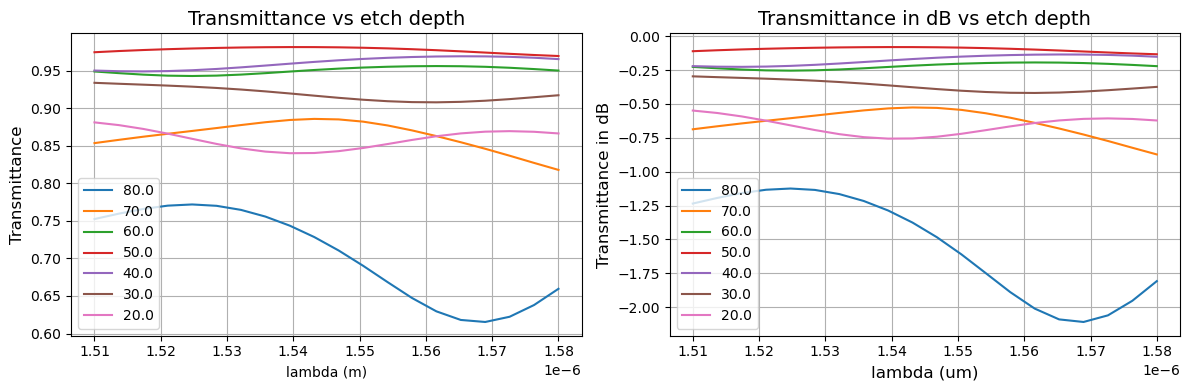

In [ ]:
# Create x-axis values (assuming equally spaced points)
x = np.linspace(1.51e-6, 1.58e-6, T_data.shape[0])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(T_data.shape[1]):
    axs[0].plot(x, T_data[:, i], label=f'Re(T) Indices: {i + 1}')
    axs[1].plot(x, 10*np.log10(T_data[:, i]), label=f'Re(T) Indices: {i + 1}')

etch_depth = np.round((np.linspace(80, 20, nop))) 

# Graph 1: Transmittance
axs[0].set_xlabel('lambda (m)',fontsize=12)
axs[0].set_ylabel('Transmittance', fontsize=12)
axs[0].set_title('Transmittance vs etch depth', fontsize=14)
axs[0].grid()
axs[0].legend(x_values)

# Graph 1: Transmittance in dB
axs[1].set_xlabel('lambda (um)', fontsize=12)
axs[1].set_ylabel('Transmittance in dB', fontsize=12)
axs[1].set_title('Transmittance in dB vs etch depth', fontsize=14)
axs[1].grid()
axs[1].legend(x_values)

plt.tight_layout()
plt.grid(True)

Plotting the transmittance graph shows us that the best etch depth through the C band is 50nm

In [394]:
field_data = (modeapi.getsweepdata(sweep_name, 'field monitor'))
reshaped_data = np.abs(np.reshape(field_data, (801, 801, 3, 20, 7)))
heatmap_mag = np.sqrt((reshaped_data[:,:, 0, :,:])**2 + (reshaped_data[:,:, 1, :,:])**2 + reshaped_data[:,:, 2, :,:]**2)

### Field plot

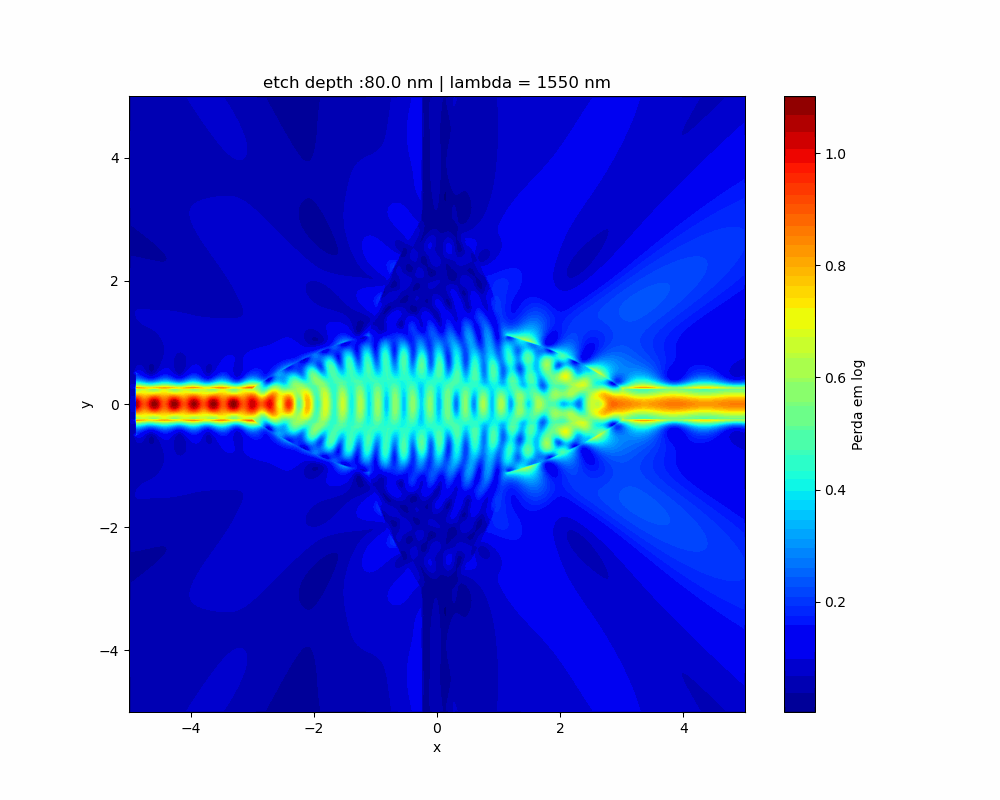

✅ GIF salvo em: C:/Users/juame/Desktop/animation.gif


In [ ]:
# Define path to save images
save_path = 'C:/Users/juame/Desktop/'
os.makedirs(save_path, exist_ok=True)


# List of frames
frames = []

# generating graphs and saving as frames
for i in range(nop):
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_mag[:, :, 9, i], cmap='jet',extent=[-5, 5, -5, 5])

    # Adding colorbar
    cbar = plt.colorbar(label='Perda em log')

    # Adding titles and labels
    plt.title(f'etch depth :{etch_depth[i]} nm | lambda = 1550 nm')
    plt.xlabel('x')
    plt.ylabel('y')
    
    # Save images
    file_path = os.path.join(save_path, f'frame_{i}.png')
    plt.savefig(file_path)
    plt.close()

    # Load GIF as frame
    frame = Image.open(file_path)
    frames.append(frame)

# Create GIF and save it on the PC
gif_path = os.path.join(save_path, 'animation.gif')
frames[0].save(gif_path, save_all=True, append_images=frames[1:], optimize=True, duration=500, loop=0)

# Showing gif in code
display(IPImage(filename=gif_path))

# showing path where GIF was saved in the pc
print(f"GIF saved in: {gif_path}")


### Results in log showing the lost of db

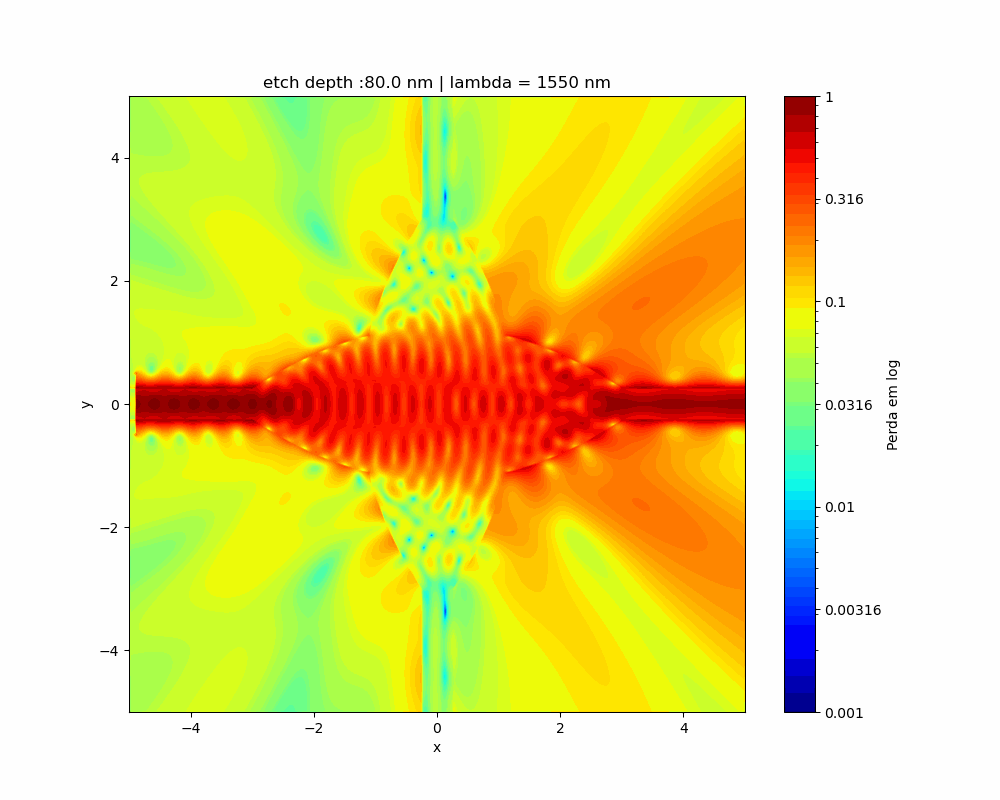

GIF saved in: C:/Users/juame/Desktop/animation.gif


In [ ]:
# Defines path to save images
save_path = 'C:/Users/juame/Desktop/'
os.makedirs(save_path, exist_ok=True)


# List of frames
frames = []

# Generate and save frames
for i in range(int(nop)):
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_mag[:, :, 9, i], cmap='jet', norm=colors.LogNorm(vmin=0.001, vmax=1),extent=[-5, 5, -5, 5])

    # Adding colorbar
    cbar = plt.colorbar(label='Perda em log')
    tick_locations = [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1]
    tick_labels = ['0.001', '0.00316', '0.01', '0.0316', '0.1', '0.316', '1']
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)

    # Ading title and labels
    plt.title(f'etch depth :{etch_depth[i]} nm | lambda = 1550 nm')
    plt.xlabel('x')
    plt.ylabel('y')

    # Save images
    file_path = os.path.join(save_path, f'frame_{i}.png')
    plt.savefig(file_path)
    plt.close()

    # Load GIF as frame
    frame = Image.open(file_path)
    frames.append(frame)

# Create GIF and save it on the PC
gif_path = os.path.join(save_path, 'animation.gif')
frames[0].save(gif_path, save_all=True, append_images=frames[1:], optimize=True, duration=500, loop=0)

# Showing gif in code
display(IPImage(filename=gif_path))

# showing path where GIF was saved in the pc
print(f"GIF saved in: {gif_path}")

plotting each graph more clearly

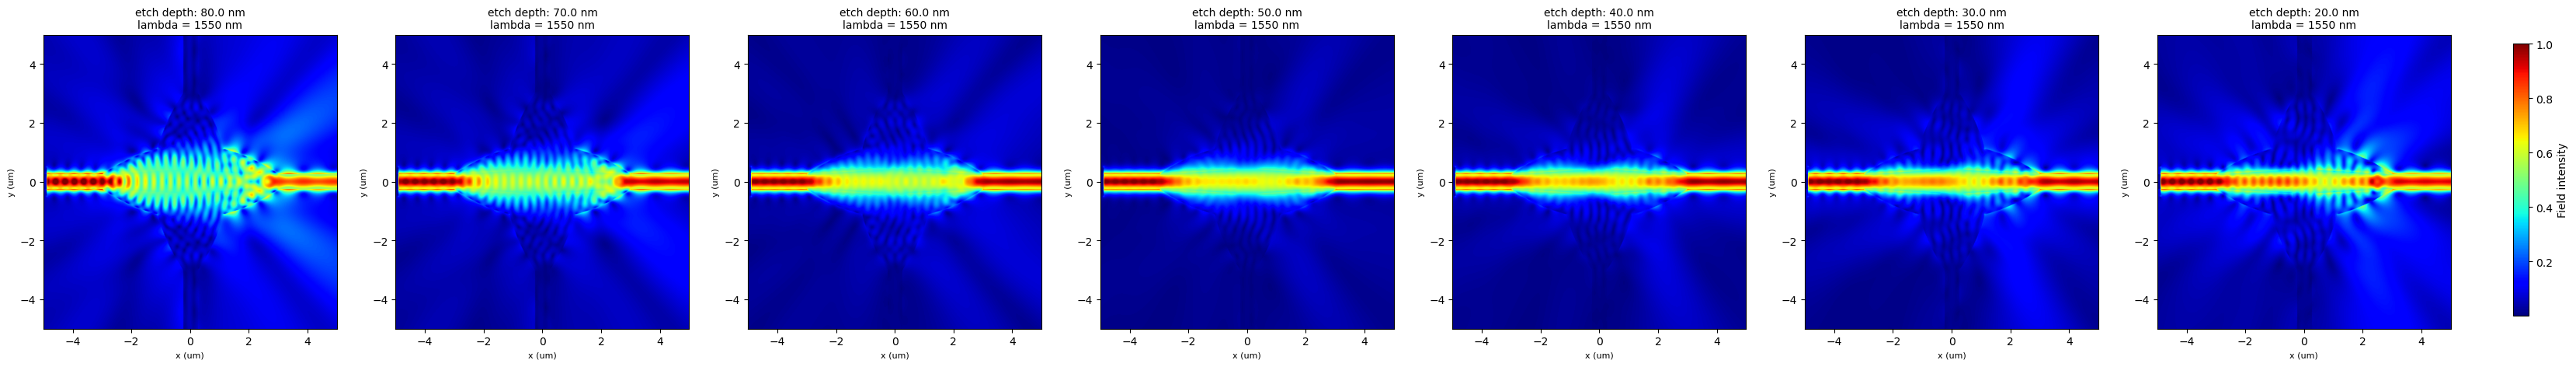

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(40, 5) )

for i in range(7):
    im = axs[i].imshow(heatmap_mag[:, :, 9, i], cmap='jet', vmin=0.001, vmax=1,extent=[-5, 5, -5, 5])
    
    axs[i].set_title(f'etch depth: {etch_depth[i]:.1f} nm\nlambda = 1550 nm', fontsize=10)
    axs[i].set_xlabel('x (um)', fontsize=8)
    axs[i].set_ylabel('y (um)', fontsize=8)

cbar_ax = fig.add_axes([0.92, 0.15, 0.005, 0.7])  # [x, y, largura, altura]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Field intensity')
plt.show()

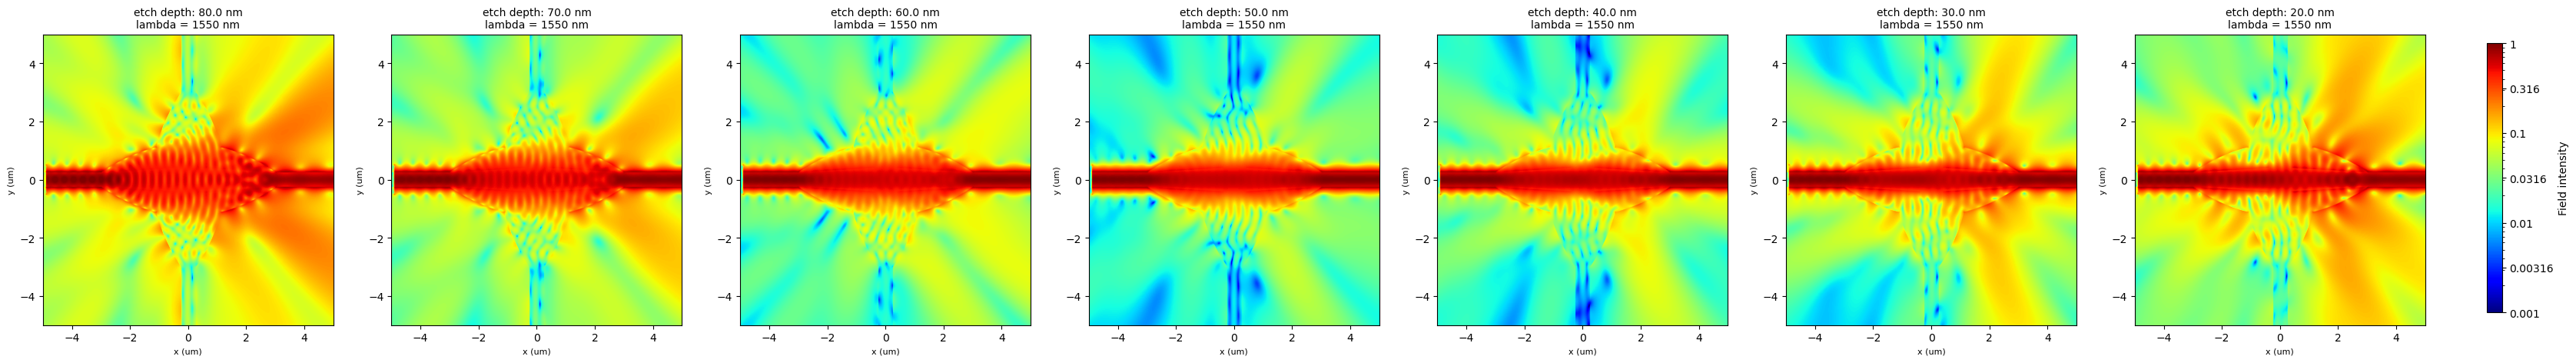

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(40, 5))

for i in range(7):
    im = axs[i].imshow(heatmap_mag[:, :, 9, i], cmap='jet', norm=colors.LogNorm(vmin=0.001, vmax=1),
                       extent=[-5, 5, -5, 5])
    
    axs[i].set_title(f'etch depth: {etch_depth[i]:.1f} nm\nlambda = 1550 nm', fontsize=10)
    axs[i].set_xlabel('x (um)', fontsize=8)
    axs[i].set_ylabel('y (um)', fontsize=8)

cbar_ax = fig.add_axes([0.92, 0.15, 0.005, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Field intensity')
tick_locations = [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1]
tick_labels = ['0.001', '0.00316', '0.01', '0.0316', '0.1', '0.316', '1']
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()